# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [1]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Calfornia has been producing more than 80% of the world almond production for many years, and is the only state that harvests almonds in the US. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11), [[3]](http://www.almonds.com/sites/default/files/Almond_Almanac_2018_F_revised.pdf). The almond tree is one of the many crops that require cross-pollination for it to bear fruits. It is simple, as almonds flowers are in bloom for a very short period of time (only some days), a lack of pollinators during this time frame would results in desastrous harvests. Thus, they and especially honey bees play a central and vital role in growing almonds. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421). Almond growers need to play hand in hand with bee keepers in order to ensure plentiful harvests. We first show the current contribution of bees to this industry, then we try to look into the effect of bee on the productivity from the 00's to 2017.

### 5.1 Loading Datasets
#### 5.1.1 Loading almond production dataset
This is a subset of the data from the [USDA](https://quickstats.nass.usda.gov/) dataset

In [2]:
california_almond = pd.read_excel('data/california_USDA_almond.xlsx', skiprows=[22], index_col='year')
california_almond.tail()

,bearing,non_bearing,yield_per_acre,production,price_per_pound,value_of_production
year,,,,,,
2013,880000,120000,2280,2010,3.21,6384690
2014,930000,170000,2010,1870,4.00,7388000
2015,950000,240000,2000,1900,3.13,5868750
2016,970000,300000,2210,2140,2.44,5052460
2017,1030000,330000,2200,2270,2.53,5603950


**Notes** on the above dataset:
- bearing, non_bearing are in acres => we want to convert into hectares (10'000 $m^2$)
- yield per acre is in pounds => we want to convert into kg/hectares
- production is in million of pounds => we want to convert into kg
- price is in \$/pound => we want to convert into kg
- value of production is thousands of \$

**Non-bearing acres** are usually areas with trees that are too young to bear fruits, as tree reaches maturity after 5-6 years [[1]](https://en.wikipedia.org/wiki/Almond#Tree)

In [3]:
HECTARE_PER_ACRE = 0.404686
KG_PER_POUND = 0.453592

# Convertion acre => hectare
california_almond.bearing *= HECTARE_PER_ACRE
california_almond.non_bearing *= HECTARE_PER_ACRE
california_almond.yield_per_acre /= HECTARE_PER_ACRE

# Convertion pound => kg
california_almond.yield_per_acre *= KG_PER_POUND
california_almond.production *= KG_PER_POUND
california_almond.price_per_pound /= KG_PER_POUND

In [4]:
# Add total harvested area
california_almond['total'] = california_almond.bearing + california_almond.non_bearing

#### 5.1.2 Loading the rest of the almond dataset from USDA
Here we only keep some columns from the dataset that are containing the relevant information of the type:
- Program: Survey (usually every year) / Census (1992, 2012, 2017)
- Time Data: Year, Period
- Geo Data: Geo Level, State, Region
- Field descriptors: Data Item, Domain, Domain Category
- Value field: Value

In [6]:
col_to_keep_almond = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Region', 'Data Item', 'Value', 'Domain', 'Domain Category']
almond_df = pd.read_csv('data/USDA_almond.csv', usecols=col_to_keep_almond)

#### 5.1.3 Loading bee inventory from USDA
We keep columns in a similar fashion as in 5.1.2

In [7]:
def parse_number(number):
    """ Helper to parse american style number to int """
    if type(number) is np.int:
        return number
    if re.search(r'[DZ]', number): # as in 4, (D), (Z) are not significant
        return 0
    try:
        return int(re.sub(r"[,'_]", "", number))
    except:
        print('Error while parsing:', number)
        return np.nan

In [8]:
col_to_keep_bee = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Data Item', 'Value', 'Domain', 'Domain Category']
bee_colony_df = pd.read_csv('data/USDA_bee_colony.csv', usecols=col_to_keep_bee)
bee_colony_df.Value = bee_colony_df.Value.apply(parse_number)

### 5.2 Contribution of bees
We first look into the effect of commercial honey bee pollination. The data is limited from 2015-2017, but it should gives us insights on where to look further in the dataset. We can explore it in 5 directions shown in the list below.

In [9]:
pollination = ['ALMONDS, HONEY BEE POLLINATION - ACRES POLLINATED, PAID BASIS',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / ACRE',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / COLONY',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN COLONIES',
               'ALMONDS, HONEY BEE POLLINATION - VALUE OF POLLINATION, MEASURED IN $']

In [10]:
pollination_df = almond_df[almond_df['Data Item'].isin(pollination)]\
                 .drop(columns=['Program', 'Period', 'Geo Level', 'State', 'Domain', 'Domain Category'])\
                 .copy()
pollination_df.Value = pollination_df.Value.apply(parse_number)

pollination_df['Data Item'] = pollination_df['Data Item'].apply(lambda x: x.lstrip('ALMONDS, HONEY BEE POLLINATION')[2:])

In [11]:
pollination_pivot = pollination_df.pivot(index='Year', columns='Data Item', values='Value')
pollination_pivot

Data Item,"ACRES POLLINATED, PAID BASIS","POLLINATION, MEASURED IN $ / ACRE","POLLINATION, MEASURED IN $ / COLONY","POLLINATION, MEASURED IN COLONIES","VALUE OF POLLINATION, MEASURED IN $"
Year,,,,,
2015,921200,313,165,1760000,290400000
2016,921400,287,167,1590000,265530000
2017,928600,272,171,1480000,253080000


**Insights**:
1. By giving a look at the data from 5.1.1 we observe that acres pollinated $\sim$ bearing area
2. It requires a high amount of colonies (1.48 to 1.76 million)
3. It costs almond growers about 250-290 millions \$ per year, which is about 5\% of the value of production
4. The price per colony is rougly constant (given the current inflation in the US)
5. In general there seems to be a decreasing amount of colonies per acres as the number of acres is constant but the number of colonies is droping. Resulting in a drop of price per acre and total cost

*Point 1*: We first compare the acres pollinated and the acres bearing

In [13]:
(pollination_pivot['ACRES POLLINATED, PAID BASIS'].apply(lambda x: x * HECTARE_PER_ACRE)
 / california_almond.bearing).dropna()

2015    0.969684
2016    0.949897
2017    0.901553
dtype: float64

We see that bees are present on more than 90% of the bearing area, this means that almond growers heavily rely on honey bees for the cross-pollination of their crops.

### 5.3 Almond production
We then dive into almond production. We would like to be able to compare the production, area bearing/non-bearing and price in order to identify patterns and particularities.

In [18]:
def autolabel(rects, ax, labels):
    """
    Attach a text label above each bar in *rects*, displaying a given label.
    Code adapted from [matplotlib doc](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)
    """
    for rect, label in zip(rects, labels):
        ax.annotate('{:.1f}'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

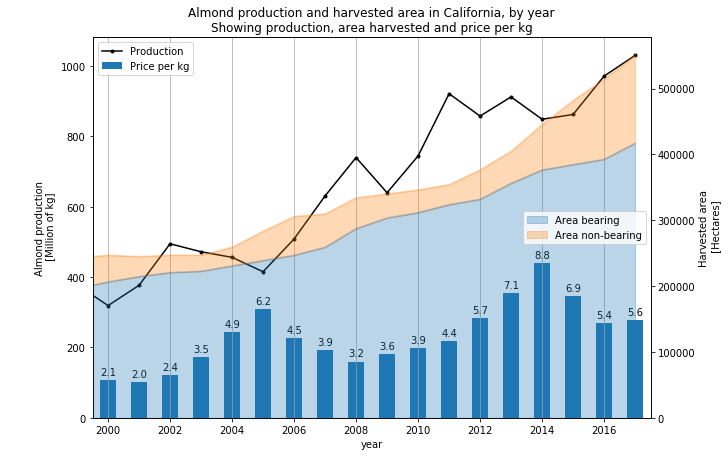

In [20]:
# Plots
fig, ax1 = plt.subplots(figsize=(10, 7))
prod_plt = california_almond.plot(y='production', style='k.-', ax=ax1, legend=True, label='Production')
price_bar = ax1.bar(x=california_almond.index, height=california_almond.price_per_pound*50, width=0.5, label='Price per kg')
autolabel(price_bar, ax1, california_almond.price_per_pound)
ax2 = ax1.twinx()
area_plt = california_almond.plot(y=['bearing', 'non_bearing'], kind='area', stacked=True, alpha=0.3, ax=ax2, legend=True, label=['Area bearing', 'Area non-bearing'])
ax2.legend(loc='center right')
ax1.legend()

plt.xlim(left=1999.5, right=2017.5)
plt.title('Almond production and harvested area in California, by year\nShowing production, area harvested and price per kg')
ax1.grid(axis='x')
plt.xlabel('Year')
#ax1.set_yscale('log')
ax1.set_ylabel('Almond production\n [Million of kg]')
ax2.set_ylabel('Harvested area\n [Hectares]')
plt.show()

**Analysis**:
1. We see that the bearing area for almonds is stricly increasing, this indicates that the industry has become more and more popular (and lucrative).
2. In the recent years, the non-bearing area has increased because farmers are replacing old trees with new varieties of more resistant, less water-consuming and even sometimes self-polinating varieties [[1]](http://www.almonds.com/processors/resources/almond-almanac)
3. We identify a high correlation (see plot below) of 0.95 between the bearing area and production
    - This clearly is a causation effect, the more area bears fruit the more almonds are available
    - Yet, we identify some outliers like sudden drops in 2009 and plateaux from 2002-2005 and 2011-2015. This needs further investigating.
4. The price has a pretty low positive correlation coefficient with the production.
    - E.g. there's a high price increase in 2014 whereas the production remained roughly stable
    - The price of almonds actually depends on other factors such as exportation and demand from foreign markets [[2]](https://www.bls.gov/opub/btn/volume-6/the-rise-and-fall-of-almond-prices-asia-drought-and-consumer-preference.htm), but we did not succeed at finding articles linking the prices of almonds to the cost of pollination

**Further analysis of production plateau and drop**
There are two main factors to decrease in almond production: a **lack of pollinators** and **water shortage**
- The 2002-2005 plateau:
    >California almond growers are once again being stung by a shortage of honeybees. [[3]](https://www.latimes.com/archives/la-xpm-2005-may-07-fi-almonds7-story.html)
    - This plateau is caused by a lack of pollinators
    - These years are also the first important reports of Colony Collapse Disorder in the media
    - The almond industry had become more dependent on migratory beekeeping (which began developping around that time)
- The 2009 drop:
    - California had been experiencing a drought and many almond growers could not irriguate their crops [[4]](https://www.growingproduce.com/fruits/impacts-of-drought-on-almond-production/)
- The 2011-2015 plateau:
    - California again experienced severe drought [[5]](https://www.growingproduce.com/fruits/impacts-of-drought-on-almond-production/)
    - What improved the situation:
        - New pollinators initiative have been undertaken to reduce the risk of a lack of pollinators, since 2014, [Honey Bee best Management Practices](http://www.almonds.com/pollination) describes how to promote discussion between beekeepers and almond growers
        - Less water consuming almond trees were planted in the wake of the 2009 drought and started to bear fruits

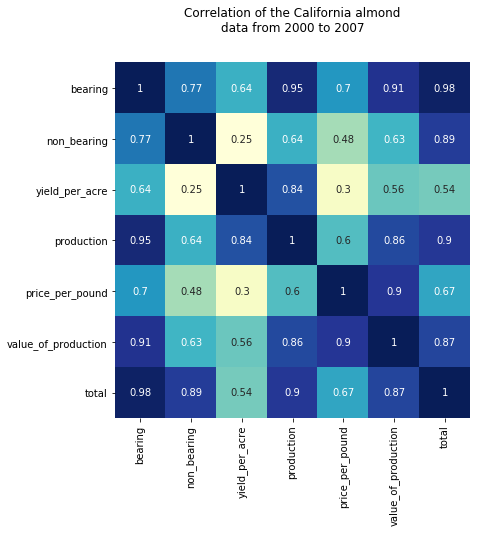

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(california_almond[california_almond.index >= 2000].corr(), annot=True, ax=ax, cbar=False, cmap='YlGnBu', square=True)
ax.set_ylim(7, -0.5)
plt.title('Correlation of the California almond\ndata from 2000 to 2007')
plt.show()

### 5.4 Bees

We finally look into the bee population and the necessary migratory beekeeping in order to sustain the almond agriculture

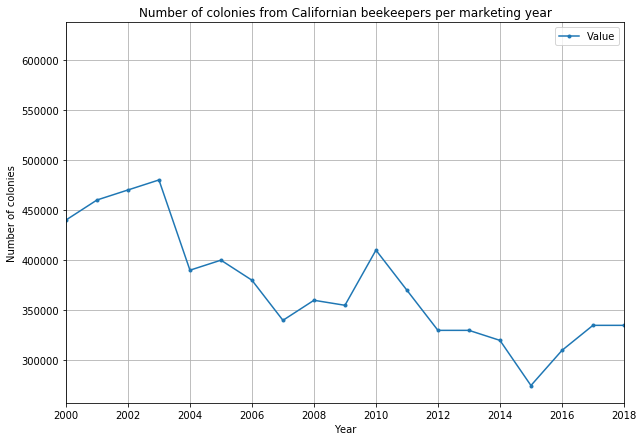

In [31]:
condition = {'Geo Level': 'STATE', 'State': 'CALIFORNIA', 'Program': 'SURVEY', 'Period': 'MARKETING YEAR'}
CAL_colony = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0)].set_index('Year')
CAL_colony.plot(y='Value', style='.-', figsize=(10, 7))
plt.title('Number of colonies from Californian beekeepers per marketing year')
plt.ylabel('Number of colonies')
plt.xlim(left=2000)
plt.grid()
plt.show()

We can clearly see that there is not enough *local* colonies to sustain the almond agriculture, with currently **less than 350'000 colonies** when the almond industry requires about **1'500'000 colonies**. This means that **at least three quarters** of the colonies need to be brought to California in order to supply the industry.

If we assume that the amount of colonies per hectare is roughly constant, we can say that California was never self-sufficient in bee colonies required for almonds during the 21st century, prompting other states beekeepers to move around the US with their colonies as the pollination price increased and started representing half of a beekeeper's revenue.

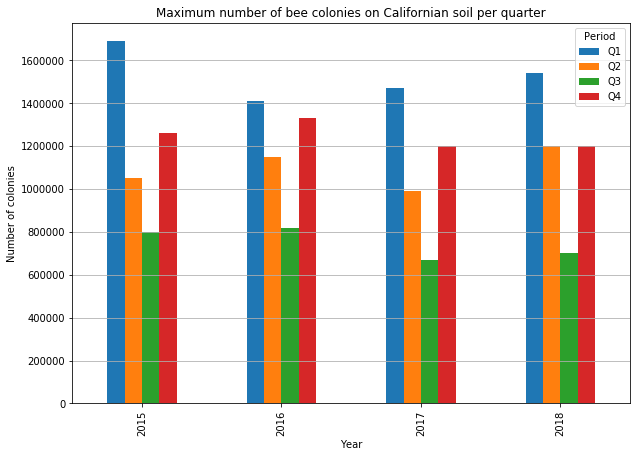

In [27]:
condition = {'Geo Level': 'STATE', 'State': 'CALIFORNIA', 'Program': 'SURVEY', 'Data Item': 'HONEY, BEE COLONIES - INVENTORY, MAX, MEASURED IN COLONIES'}
map_period = {'JAN THRU MAR': 'Q1', 'APR THRU JUN': 'Q2', 'JUL THRU SEP': 'Q3', 'OCT THRU DEC': 'Q4'}
CAL_colony_max = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0) & (bee_colony_df.Year < 2019)].copy()
CAL_colony_max.Period = CAL_colony_max.Period.map(map_period)

CAL_colony_max.pivot(index='Year', columns='Period', values='Value').plot.bar(figsize=(10, 7))

plt.title('Maximum number of bee colonies on Californian soil per quarter')
plt.ylabel('Number of colonies')
plt.grid(axis='y')
plt.show()

We can clearly see that the maximum number of bee colonies on Californian soil far exceed the number of local colonies. This is especially true during Quarter 1 (January through March) when the almond tree bloom (mid-february). We see that during Q1, the number of colonies meets the demand of the almond industry. During the other quarters, there is less colonies in California as, as seen in Research Question 4, the beekeepers are busy in other states with their bees.

### 5.5 Conclusion
It is clear that bees play a central role in pollinating almond trees being present in more than 90% of the bearing orchads. A lack of bees results in a stagnant almond production but is not the only factor to take into account, as California is more and more exposed to extreme weather and drought. Thus, almond growers need to rely on migratory beekeepers for the pollination and new varieties of trees to face the future.